In [9]:
import pandas as pd
import json
import os
def read_result(model: str, prompt_name: str, dataset_name: str = 'MMLU'):
    """Read a specific result file"""
    # Construct the file path
    file_path = f'data/results/{model}/{dataset_name}_{prompt_name}.json'
    
    # Read the JSON file
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    # Convert results to DataFrame
    df = pd.DataFrame(data['results'])
    df['prompt_type'] = prompt_name
    # Add metadata as columns
    # for key, value in data['metadata'].items():
    #     df[f'metadata_{key}'] = value
    return df

In [10]:
def read_all_results(base_dir='data/results/', dataset_name: str = 'MMLU'):
    """Read and combine results from all models and prompts"""
    # Define models and prompts based on your script
    models = [
        'gpt-4o-mini',
        'gpt-4-turbo',
        'claude-3-5-haiku-20241022'
    ]
    
    prompts = ['base', 'CoT']
    
    all_dfs = []
    
    for model in models:
        for prompt in prompts:
            try:
                # Construct file path
                file_path = os.path.join(base_dir, model, f'{dataset_name}_{prompt}.json')
                
                # Read the JSON file if it exists
                if os.path.exists(file_path):
                    with open(file_path, 'r') as f:
                        data = json.load(f)
                        
                    # Convert results to DataFrame
                    if 'results' in data:
                        df = pd.DataFrame(data['results'])
                        df['prompt_type'] = prompt
                        
                        all_dfs.append(df)
                    else:
                        print(f"No results found in {file_path}")
                
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
    
    # Combine all dataframes
    if all_dfs:
        combined_df = pd.concat(all_dfs, ignore_index=True)
        return combined_df
    else:
        print("No data found")
        return None

# Example usage:
df_combined = read_all_results()

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.calibration import calibration_curve


def enhance_dataframe(df):
    """Add analysis columns to the dataframe"""
    def extract_direct_answer(row):
        """Extract the direct answer based on the correct option"""
        parts = row['question_text'].split('The options are:')
        if len(parts) < 2:
            return None
            
        options_text = parts[1]
        
        # Create a map of options
        options = {}
        for i, option in enumerate(['A', 'B', 'C', 'D', 'E']):
            if i < len(['A', 'B', 'C', 'D', 'E']) - 1:  # For all options except the last one
                # Look ahead until the next option
                pattern = rf'{option}\)\s*(.*?)(?=[ABCDE]\)|$)'
            else:  # For the last option
                pattern = rf'{option}\)\s*(.*?)$'
            
            match = re.search(pattern, options_text)
            if match:
                value = match.group(1).strip()
                # Remove trailing comma if present
                value = value.rstrip(',')
                options[option] = value
    
        return options.get(row['correct_answer'])
    
    def get_full_answer(row):
        """Get the full answer (option + value)"""
        parts = row['question_text'].split('The options are:')
        if len(parts) < 2:
            return None
            
        options_text = parts[1]
        for i, option in enumerate(['A', 'B', 'C', 'D', 'E']):
            if option == row['correct_answer']:
                if i < len(['A', 'B', 'C', 'D', 'E']) - 1:
                    pattern = rf'{option}\)\s*(.*?)(?=[ABCDE]\)|$)'
                else:
                    pattern = rf'{option}\)\s*(.*?)$'
                
                match = re.search(pattern, options_text)
                if match:
                    value = match.group(1).strip().rstrip(',')
                    return f"{option}) {value}"
        return None
    
    def check_answer_correctness(row):
        """Check if the answer matches any of the correct answer formats"""
        if pd.isna(row['answer']) or pd.isna(row['correct_answer']):
            return False
            
        # Convert everything to strings, strip whitespace and trailing commas
        answer = str(row['answer']).strip().rstrip(',')
        correct_option = str(row['correct_answer']).strip()
        direct_answer = str(row['correct_direct_answer']).strip().rstrip(',')
        full_answer = str(row['correct_full_answer']).strip().rstrip(',')
        
        # Standardize spaces and remove any trailing commas
        standardize = lambda x: x.replace(' ', '').rstrip(',')
        answer = standardize(answer)
        correct_option = standardize(correct_option)
        direct_answer = standardize(direct_answer)
        full_answer = standardize(full_answer)
        
        # Check against all formats
        return (answer == correct_option or  # Option only (e.g., "A")
                answer == direct_answer or    # Direct value (e.g., "2,3")
                answer == full_answer or      # Full answer (e.g., "C) 2,3")
                # Handle case where answer might have extra formatting
                answer in [correct_option, direct_answer, full_answer])

    # Add new columns
    df['correct_direct_answer'] = df.apply(extract_direct_answer, axis=1)
    df['correct_full_answer'] = df.apply(get_full_answer, axis=1)
    df['is_correct'] = df.apply(check_answer_correctness, axis=1)
    
    return df

def plot_confidence_analysis(df):
    """Create visualizations for confidence-correctness relationship"""
    plt.figure(figsize=(15, 10))
    
    # 1. Box plot of confidence distribution for correct vs incorrect answers
    plt.subplot(2, 2, 1)
    sns.boxplot(x='is_correct', y='confidence', data=df)
    plt.title('Confidence Distribution by Answer Correctness')
    plt.xlabel('Answer Correct')
    plt.ylabel('Confidence')

    # 2. Violin plot for more detailed distribution
    plt.subplot(2, 2, 2)
    sns.violinplot(x='is_correct', y='confidence', data=df)
    plt.title('Confidence Distribution (Violin Plot)')
    plt.xlabel('Answer Correct')
    plt.ylabel('Confidence')

    # 3. Histogram of confidence values for correct/incorrect answers
    plt.subplot(2, 2, 3)
    sns.histplot(data=df, x='confidence', hue='is_correct', multiple="layer", alpha=0.5)
    plt.title('Confidence Distribution Histogram')
    plt.xlabel('Confidence')
    plt.ylabel('Count')

    # 4. Custom confidence threshold analysis
    plt.subplot(2, 2, 4)
    
    # Create custom thresholds based on actual data distribution
    unique_confidences = sorted(df['confidence'].unique())
    accuracies = []
    counts = []
    
    for threshold in unique_confidences:
        mask = df['confidence'] >= threshold
        subset = df[mask]
        accuracies.append(subset['is_correct'].mean())
        counts.append(len(subset))

    ax1 = plt.gca()
    ax2 = ax1.twinx()
    
    # Plot with actual confidence values
    ax1.plot(unique_confidences, accuracies, 'b-', label='Accuracy')
    ax2.plot(unique_confidences, counts, 'r--', label='Sample Count')
    
    ax1.set_xlabel('Confidence Threshold')
    ax1.set_ylabel('Accuracy Rate', color='b')
    ax2.set_ylabel('Sample Count', color='r')
    plt.title('Accuracy vs Confidence Threshold')

    plt.tight_layout()
    return plt.gcf()

def clean_confidence_values(df):
    """Clean and convert confidence values to proper numeric format"""
    def clean_confidence(value):
        if pd.isna(value):
            return None
        # Convert to string and clean
        value_str = str(value)
        # If it's a repeated pattern, take the first value
        try:
            return float(value_str)
        except ValueError:
            print(f"Could not convert value: {value}")
            return None

    df['confidence'] = df['confidence'].apply(clean_confidence)
    return df
    



def analyze_models(df_combined):
    """Comprehensive analysis of model performance and calibration"""
    # First enhance the dataframe with correctness columns
    df = enhance_dataframe(df_combined)
    
    # Basic statistics by model
    print("\nModel Performance Summary:")
    model_stats = df.groupby(['model', 'prompt_type']).agg({
        'is_correct': ['mean', 'count'],
        'confidence': ['mean', 'std']
    }).round(3)
    print(model_stats)
    
    # Create visualization grid
    plt.figure(figsize=(20, 15))
    
    # 1. Overall accuracy by model and prompt type
    plt.subplot(2, 2, 1)
    sns.barplot(data=df, x='model', y='is_correct', hue='prompt_type')
    plt.title('Accuracy by Model and Prompt Type')
    plt.xticks(rotation=45)
    plt.ylabel('Accuracy')
    
    # 2. Calibration curves for each model
    plt.subplot(2, 2, 2)
    models = df['model'].unique()
    colors = sns.color_palette('husl', n_colors=len(models))
    
    for model, color in zip(models, colors):
        model_data = df[df['model'] == model]
        
        # Calculate calibration curve
        prob_true, prob_pred = calibration_curve(
            model_data['is_correct'],
            model_data['confidence'],
            n_bins=10,
            strategy='quantile'
        )
        
        plt.plot(prob_pred, prob_true, marker='o', label=model, color=color)
    
    # Add diagonal perfect calibration line
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
    plt.xlabel('Predicted Probability (Confidence)')
    plt.ylabel('True Probability (Accuracy)')
    plt.title('Calibration Curves by Model')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 3. Confidence distribution by model
    plt.subplot(2, 2, 3)
    sns.violinplot(data=df, x='model', y='confidence', hue='is_correct')
    plt.title('Confidence Distribution by Model and Correctness')
    plt.xticks(rotation=45)
    
    # 4. Error analysis: Confidence in wrong answers
    plt.subplot(2, 2, 4)
    wrong_answers = df[~df['is_correct']]
    sns.boxplot(data=wrong_answers, x='model', y='confidence')
    plt.title('Confidence in Wrong Answers by Model')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    
    # Additional analysis: Create ECE (Expected Calibration Error) plot
    plt.figure(figsize=(15, 5))
    
    def calculate_ece(y_true, y_pred, n_bins=10):
        """Calculate Expected Calibration Error"""
        bin_boundaries = np.linspace(0, 1, n_bins + 1)
        bin_lowers = bin_boundaries[:-1]
        bin_uppers = bin_boundaries[1:]
        
        ece = 0
        for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
            # Find predictions in this bin
            in_bin = np.logical_and(y_pred > bin_lower, y_pred <= bin_upper)
            if any(in_bin):
                bin_conf = np.mean(y_pred[in_bin])
                bin_acc = np.mean(y_true[in_bin])
                bin_size = np.sum(in_bin)
                ece += (bin_size / len(y_pred)) * abs(bin_conf - bin_acc)
        return ece
    
    ece_scores = {}
    for model in models:
        model_data = df[df['model'] == model]
        ece = calculate_ece(
            model_data['is_correct'].values,
            model_data['confidence'].values
        )
        ece_scores[model] = ece
    
    # Plot ECE scores
    plt.bar(ece_scores.keys(), ece_scores.values())
    plt.title('Expected Calibration Error by Model')
    plt.xticks(rotation=45)
    plt.ylabel('ECE (lower is better)')
    
    # Print detailed statistics
    print("\nDetailed Statistics:")
    for model in models:
        model_data = df[df['model'] == model]
        print(f"\nModel: {model}")
        print(f"Overall Accuracy: {model_data['is_correct'].mean():.3f}")
        print(f"Average Confidence: {model_data['confidence'].mean():.3f}")
        print(f"ECE Score: {ece_scores[model]:.3f}")
        
        # Overconfidence analysis
        overconf_rate = np.mean(model_data['confidence'] > model_data['is_correct'])
        print(f"Overconfidence Rate: {overconf_rate:.3f}")
        
        # Confidence-binned accuracy
        conf_bins = pd.qcut(model_data['confidence'], q=5)
        acc_by_conf = model_data.groupby(conf_bins)['is_correct'].mean()
        print("\nAccuracy by confidence quintile:")
        print(acc_by_conf)
    
    return df, ece_scores

# Example usage:
# df_combined = read_all_results()  # Your function to read all results
# enhanced_df, ece_scores = analyze_models(df_combined)
# plt.show()

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.calibration import calibration_curve

def run_complete_analysis(df_raw):
    """
    Run a complete analysis pipeline on the model data
    
    Parameters:
    df_raw (pd.DataFrame): Raw dataframe containing model predictions and actual results
    
    Returns:
    tuple: (processed_df, figures, statistics)
    """
    try:
        # 1. Data Preprocessing
        df = df_raw.copy()
        df = clean_confidence_values(df)
        df = enhance_dataframe(df)
        
        # Validate required columns
        required_columns = ['model', 'prompt_type', 'confidence', 'answer', 'correct_answer', 'question_text']
        missing_columns = [col for col in required_columns if col not in df.columns]
        if missing_columns:
            raise ValueError(f"Missing required columns: {missing_columns}")
            
        # 2. Create figures dictionary to store all plots
        figures = {}
        
        # 3. Generate analysis plots
        # Main analysis plot
        fig_main = plt.figure(figsize=(20, 15))
        
        # Overall accuracy by model and prompt type
        plt.subplot(2, 2, 1)
        sns.barplot(data=df, x='model', y='is_correct', hue='prompt_type')
        plt.title('Accuracy by Model and Prompt Type')
        plt.xticks(rotation=45)
        plt.ylabel('Accuracy')
        
        # Calibration curves
        plt.subplot(2, 2, 2)
        models = df['model'].unique()
        colors = sns.color_palette('husl', n_colors=len(models))
        
        for model, color in zip(models, colors):
            model_data = df[df['model'] == model]
            if len(model_data) > 0:  # Only process if we have data
                prob_true, prob_pred = calibration_curve(
                    model_data['is_correct'],
                    model_data['confidence'],
                    n_bins=min(10, len(model_data) // 10),  # Adjust bins based on data size
                    strategy='quantile'
                )
                plt.plot(prob_pred, prob_true, marker='o', label=model, color=color)
        
        plt.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
        plt.xlabel('Predicted Probability (Confidence)')
        plt.ylabel('True Probability (Accuracy)')
        plt.title('Calibration Curves by Model')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Confidence distribution
        plt.subplot(2, 2, 3)
        sns.violinplot(data=df, x='model', y='confidence', hue='is_correct')
        plt.title('Confidence Distribution by Model and Correctness')
        plt.xticks(rotation=45)
        
        # Wrong answers analysis
        plt.subplot(2, 2, 4)
        wrong_answers = df[~df['is_correct']]
        if len(wrong_answers) > 0:  # Only plot if we have wrong answers
            sns.boxplot(data=wrong_answers, x='model', y='confidence')
            plt.title('Confidence in Wrong Answers by Model')
            plt.xticks(rotation=45)
        
        plt.tight_layout()
        figures['main_analysis'] = fig_main
        
        # ECE Analysis
        fig_ece = plt.figure(figsize=(15, 5))
        ece_scores = calculate_ece_scores(df)
        plt.bar(ece_scores.keys(), ece_scores.values())
        plt.title('Expected Calibration Error by Model')
        plt.xticks(rotation=45)
        plt.ylabel('ECE (lower is better)')
        figures['ece_analysis'] = fig_ece
        
        # Confidence Analysis
        figures['confidence_analysis'] = plot_confidence_analysis(df)
        
        # 4. Generate statistics
        statistics = generate_statistics(df, ece_scores)
        
        return df, figures, statistics
        
    except Exception as e:
        print(f"Error in analysis pipeline: {str(e)}")
        raise

def calculate_ece_scores(df):
    """Calculate Expected Calibration Error for each model"""
    def calculate_single_ece(y_true, y_pred, n_bins=10):
        bin_boundaries = np.linspace(0, 1, n_bins + 1)
        bin_lowers = bin_boundaries[:-1]
        bin_uppers = bin_boundaries[1:]
        
        ece = 0
        for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
            in_bin = np.logical_and(y_pred > bin_lower, y_pred <= bin_upper)
            if any(in_bin):
                bin_conf = np.mean(y_pred[in_bin])
                bin_acc = np.mean(y_true[in_bin])
                bin_size = np.sum(in_bin)
                ece += (bin_size / len(y_pred)) * abs(bin_conf - bin_acc)
        return ece
    
    ece_scores = {}
    for model in df['model'].unique():
        model_data = df[df['model'] == model]
        if len(model_data) > 0:
            ece = calculate_single_ece(
                model_data['is_correct'].values,
                model_data['confidence'].values
            )
            ece_scores[model] = ece
    return ece_scores

def generate_statistics(df, ece_scores):
    """Generate comprehensive statistics for each model"""
    statistics = {}
    
    # Overall statistics
    overall_stats = df.groupby(['model', 'prompt_type']).agg({
        'is_correct': ['mean', 'count'],
        'confidence': ['mean', 'std']
    }).round(3)
    statistics['overall'] = overall_stats
    
    # Detailed model statistics
    model_stats = {}
    for model in df['model'].unique():
        model_data = df[df['model'] == model]
        
        model_stats[model] = {
            'accuracy': model_data['is_correct'].mean(),
            'avg_confidence': model_data['confidence'].mean(),
            'ece_score': ece_scores.get(model, np.nan),
            'overconfidence_rate': np.mean(model_data['confidence'] > model_data['is_correct']),
            'sample_count': len(model_data)
        }
        
        # Confidence-binned accuracy
        try:
            conf_bins = pd.qcut(model_data['confidence'], q=5)
            acc_by_conf = model_data.groupby(conf_bins)['is_correct'].mean()
            model_stats[model]['accuracy_by_confidence'] = acc_by_conf.to_dict()
        except ValueError:  # Handle cases with too few unique values
            model_stats[model]['accuracy_by_confidence'] = None
            
    statistics['by_model'] = model_stats
    
    return statistics

# Usage example:
def analyze_all(df):
    """
    Wrapper function to run all analyses and display results
    
    Parameters:
    df (pd.DataFrame): Input dataframe with model predictions
    
    Returns:
    tuple: (processed_df, figures, statistics)
    """
    try:
        # Run complete analysis
        processed_df, figures, statistics = run_complete_analysis(df)
        
        # Display statistics
        print("\nModel Performance Summary:")
        print(statistics['overall'])
        
        print("\nDetailed Statistics by Model:")
        for model, stats in statistics['by_model'].items():
            print(f"\nModel: {model}")
            print(f"Overall Accuracy: {stats['accuracy']:.3f}")
            print(f"Average Confidence: {stats['avg_confidence']:.3f}")
            print(f"ECE Score: {stats['ece_score']:.3f}")
            print(f"Overconfidence Rate: {stats['overconfidence_rate']:.3f}")
            print(f"Sample Count: {stats['sample_count']}")
            
            if stats['accuracy_by_confidence']:
                print("\nAccuracy by confidence quintile:")
                for bin_range, acc in stats['accuracy_by_confidence'].items():
                    print(f"{bin_range}: {acc:.3f}")
        
        # Display all figures
        for fig_name, fig in figures.items():
            plt.figure(fig.number)
            plt.show()
            
        return processed_df, figures, statistics
        
    except Exception as e:
        print(f"Error in analysis: {str(e)}")
        raise


Model Performance Summary:
                                      is_correct       confidence       
                                            mean count       mean    std
model                     prompt_type                                   
claude-3-5-haiku-20241022 CoT               0.30    50      0.924  0.025
                          base              0.30    50      0.925  0.025
gpt-4-turbo               CoT               0.30    50      0.992  0.023
                          base              0.46    50      0.988  0.026
gpt-4o-mini               CoT               0.30    50      0.958  0.050
                          base              0.34    50      0.870  0.178

Detailed Statistics by Model:

Model: gpt-4o-mini
Overall Accuracy: 0.320
Average Confidence: 0.914
ECE Score: 0.630
Overconfidence Rate: 0.680
Sample Count: 100

Model: gpt-4-turbo
Overall Accuracy: 0.380
Average Confidence: 0.990
ECE Score: 0.610
Overconfidence Rate: 0.620
Sample Count: 100

Model: claude-3-5-h

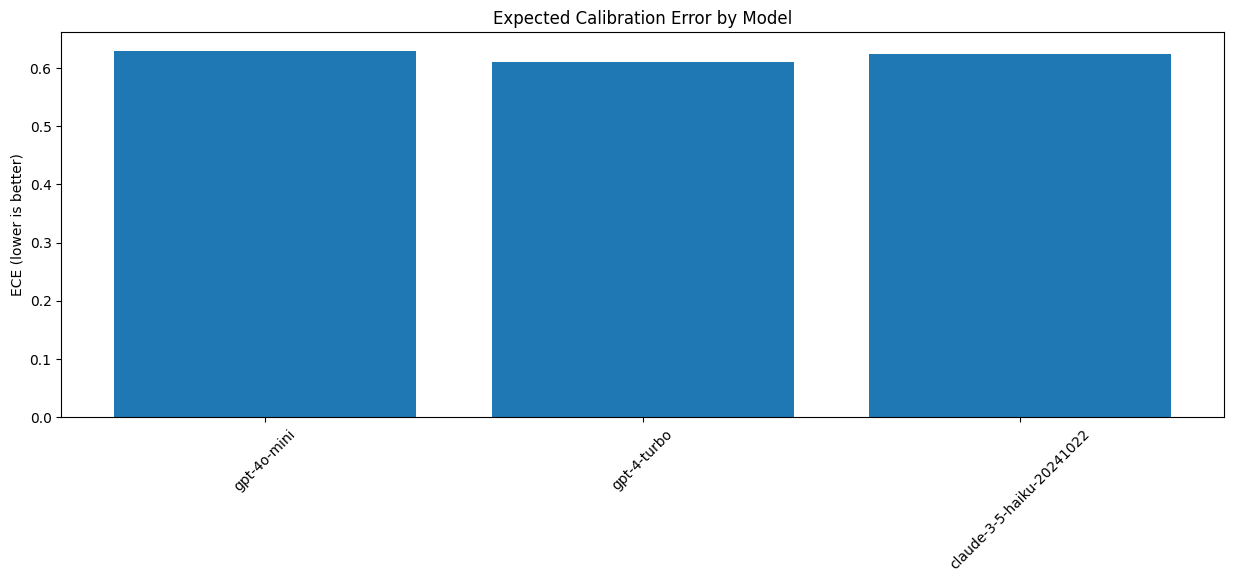

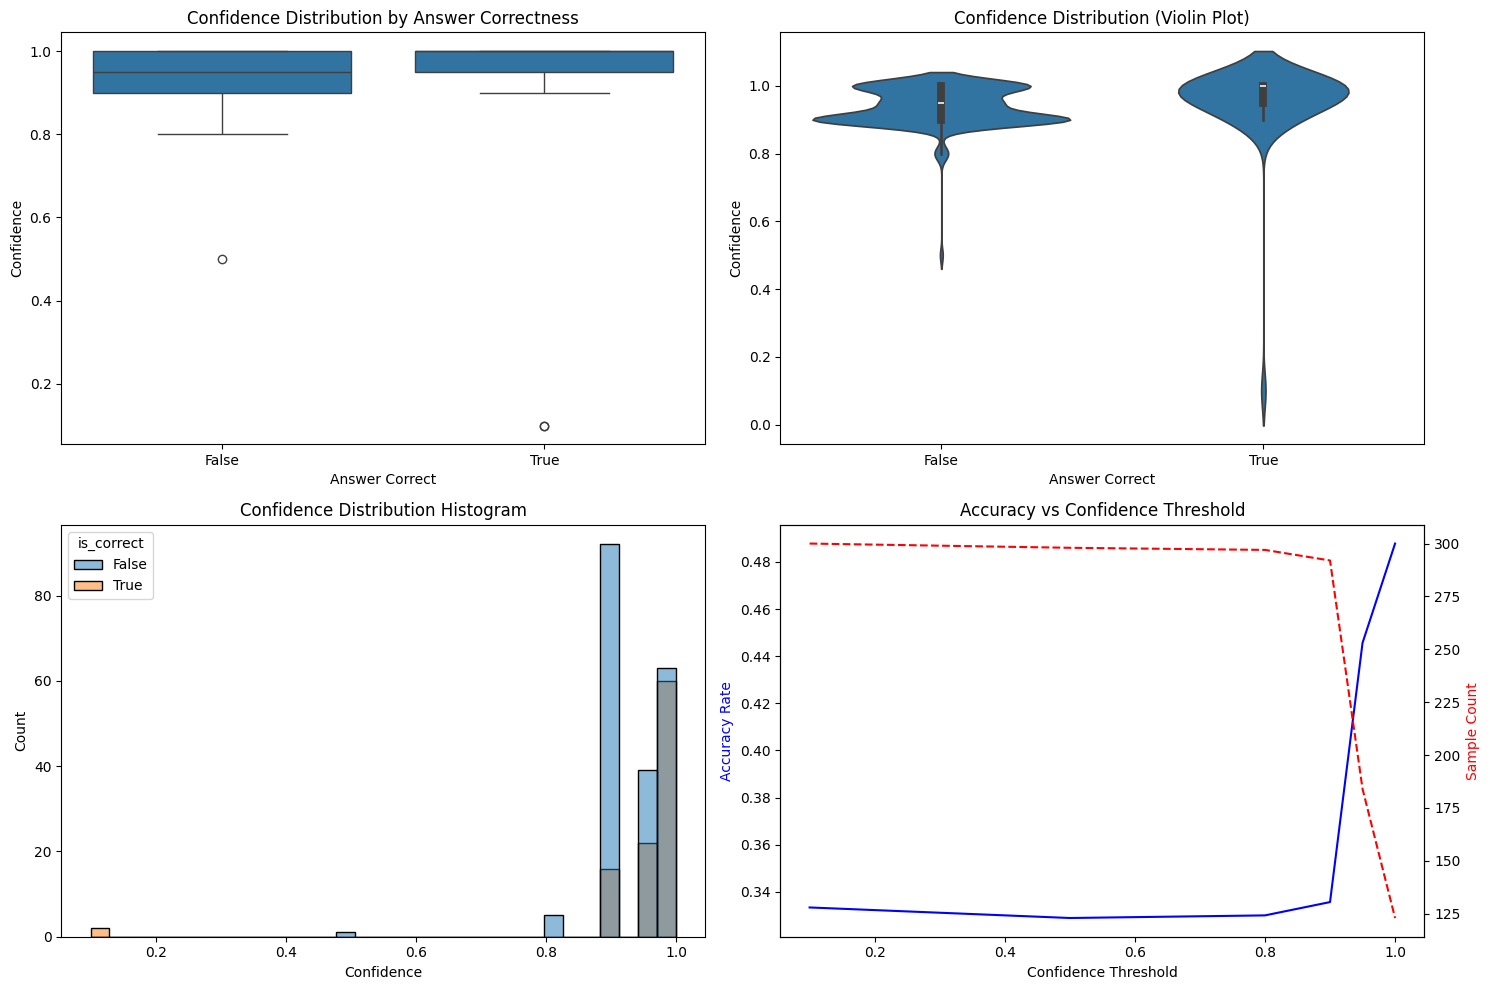

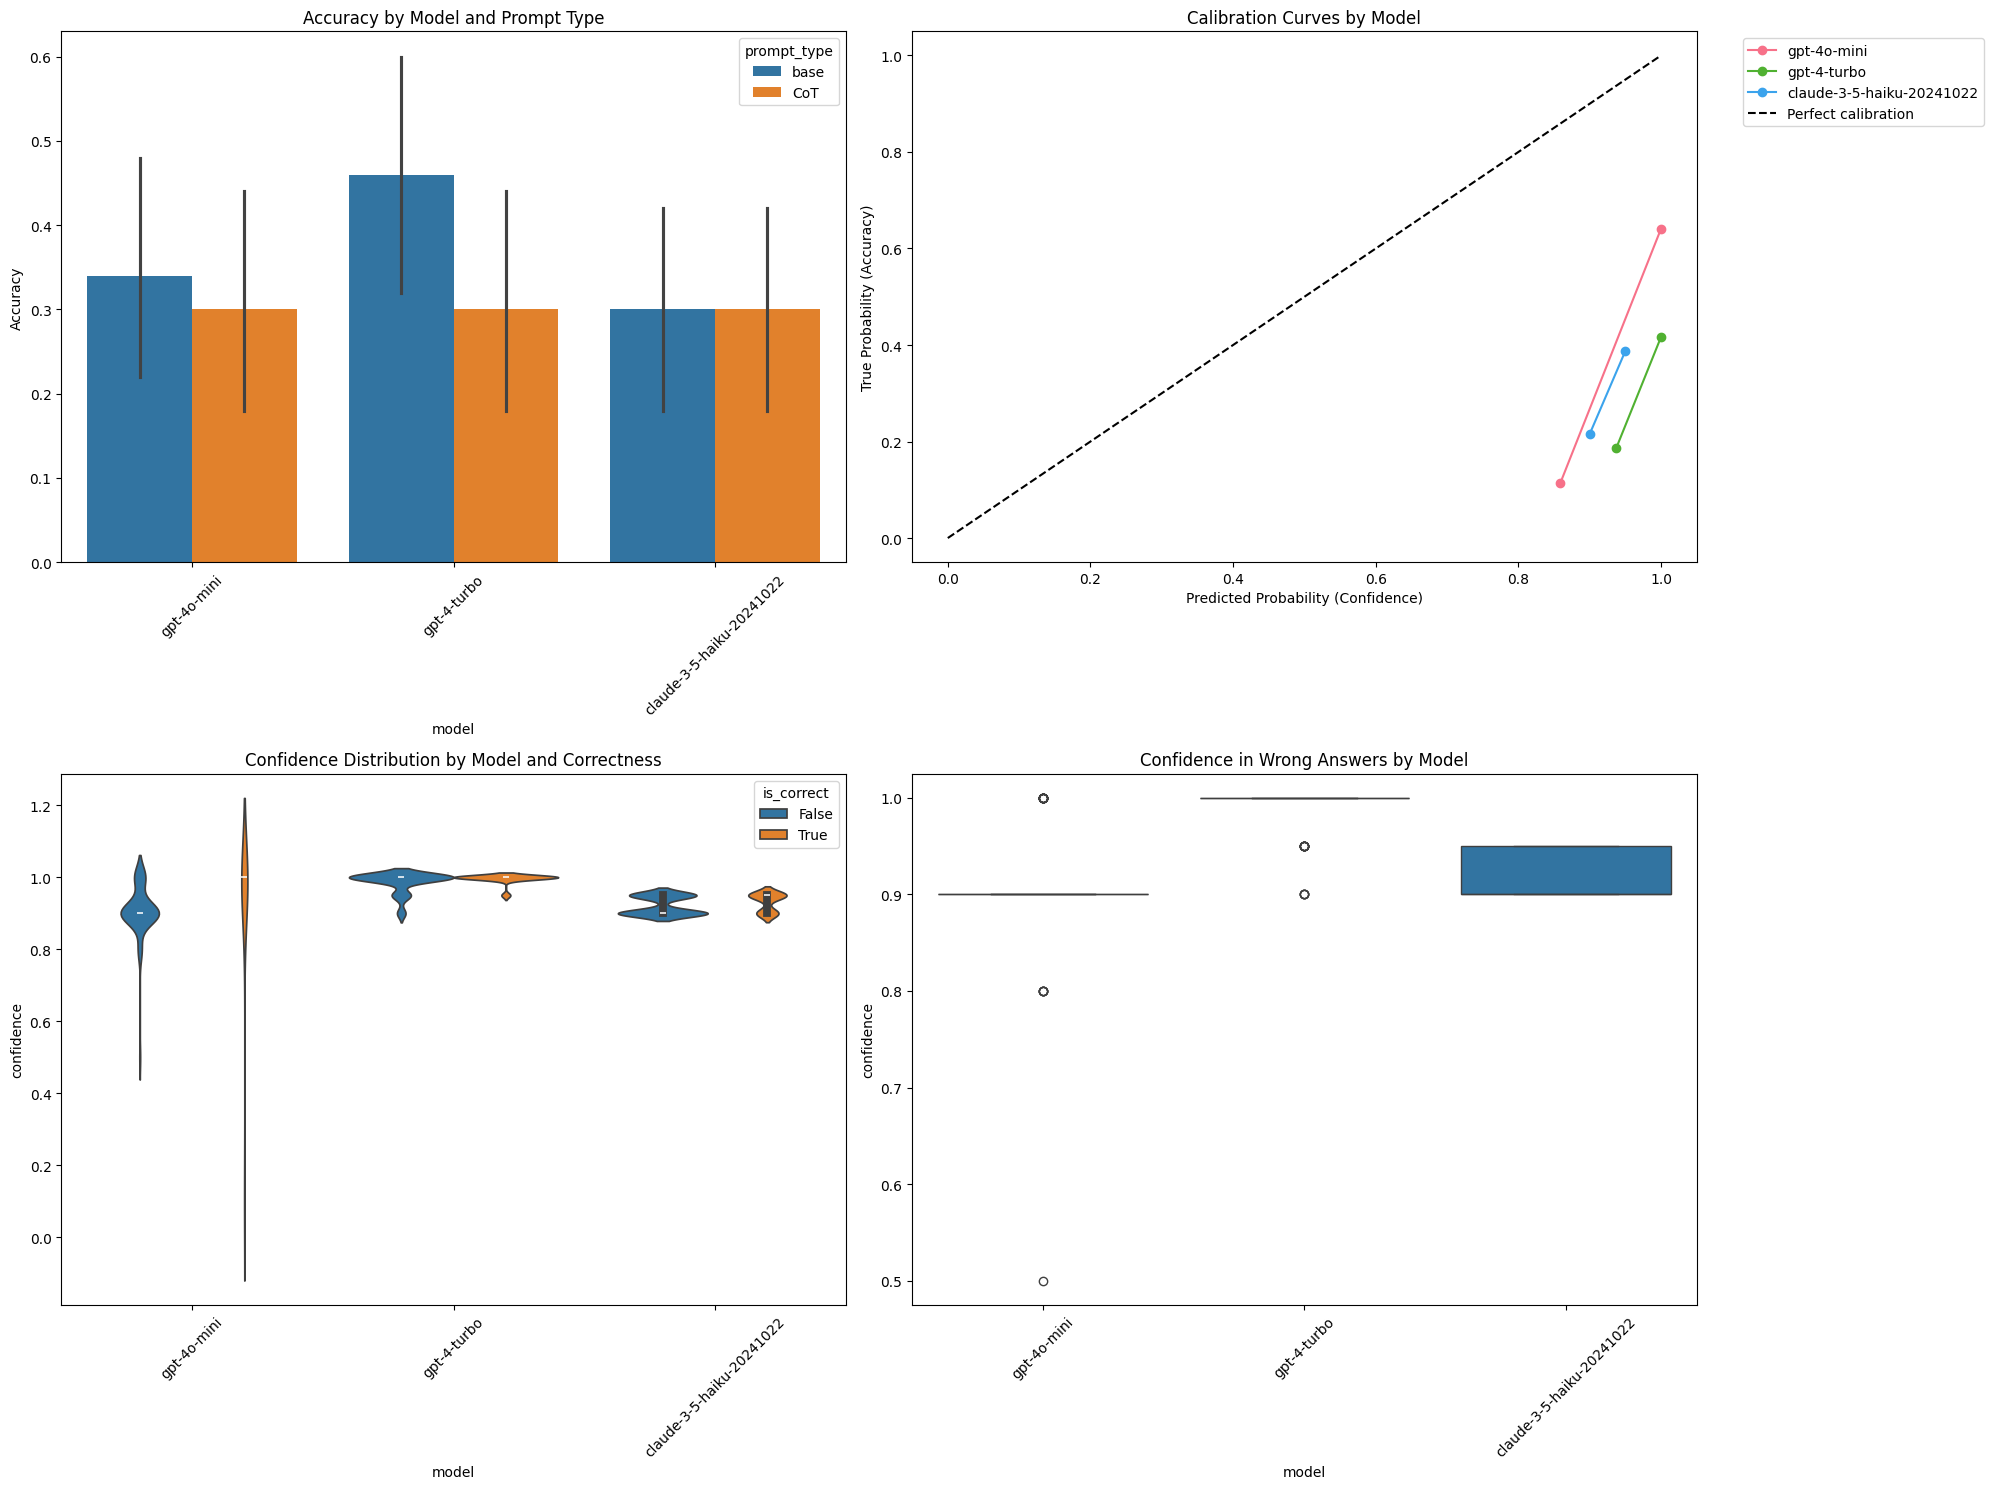

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

(     question_id          category       name  \
 0              0  abstract_algebra  MMLU_test   
 1              0  abstract_algebra  MMLU_test   
 2              0  abstract_algebra  MMLU_test   
 3              0  abstract_algebra  MMLU_test   
 4              0  abstract_algebra  MMLU_test   
 ..           ...               ...        ...   
 295            9  abstract_algebra  MMLU_test   
 296            9  abstract_algebra  MMLU_test   
 297            9  abstract_algebra  MMLU_test   
 298            9  abstract_algebra  MMLU_test   
 299            9  abstract_algebra  MMLU_test   
 
                                          question_text correct_answer  \
 0    Find the degree for the given field extension ...              B   
 1    Find the degree for the given field extension ...              B   
 2    Find the degree for the given field extension ...              B   
 3    Find the degree for the given field extension ...              B   
 4    Find the degree for th

In [18]:
analyze_all(df_combined)